# This notebook is for the development of a pipeline for unsupervised learning on accelerometer data. A public dataset is used, since the eventual intended dataset for the project is not available yet.

## The dataset used in this notebook is the FORTH_TRACE_DATASET 

### Katerina Karagiannaki, Athanasia Panousopoulou, & Panagiotis Tsakalides. (2016). The FORTH-TRACE dataset for human activity recognition of simple activities and postural transitions using a Body Area Network [Data set]. Zenodo. http://doi.org/10.5281/zenodo.841301

The dataset is collected from 15 participants wearing 5 Shimmer sensor nodes 
on the locations listed in Table 1. The participants performed a series of 16 
activities (7 basic and 9 postural transitions), listed in Table 2.

The captured signals are the following:
3-axis accelerometer
3-axis gyroscope
3-axis magnetometer

The sampling rate of the devices is set to 51.2 Hz.

--------------------------------------------------------------------------------
		DATASET FILES
--------------------------------------------------------------------------------
The dataset contains the following files:

partX/partXdev1.csv
partX/partXdev2.csv
partX/partXdev3.csv
partX/partXdev4.csv
partX/partXdev5.csv

Where X corresponds to the participant ID, 
and numbers 1-5 to the device ID (Table 1).

Each .csv file has the following format:

Column1: Device ID
Column2: accelerometer x
Column3: accelerometer y
Column4: accelerometer z
Column5: gyroscope x
Column6: gyroscope y
Column7: gyroscope z
Column8: magnetometer x
Column9: magnetometer y
Column10: magnetometer z
Column11: Timestamp
Column12: Activity Label

--------------------------------------------------------------------------------
		Table 1: LOCATIONS
--------------------------------------------------------------------------------
1. Left Wrist
2. Right Wrist
3. Torso
4. Right Thigh
5. Left Ankle

--------------------------------------------------------------------------------
		Table 2: ACTIVITY LABELS
--------------------------------------------------------------------------------
(Arrows (->) indicate transitions between activities)

1. stand 
2. sit 
3. sit and talk 
4. walk 
5. walk and talk 
6. climb stairs (up/down) 
7. climb stairs (up/down) and talk 
8. stand -> sit 
9. sit -> stand 
10. stand -> sit and talk 
11. sit and talk -> stand 
12. stand -> walk 
13. walk -> stand 
14. stand -> climb stairs (up/down), stand -> climb stairs (up/down) and talk 
15. climb stairs (up/down) -> walk 
16. climb stairs (up/down) and talk -> walk and talk 

### Part 0: Imports

In [1]:
import math
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import statistics 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler, StandardScaler

### Part 1: Data parsing

In [2]:
data_location = "/home/jack/data/FORTH_TRACE_DATASET-master"

# Creates strings for parsing over the file structure of the dataset
participant_IDs = ["part" + str(x) for x in range(15)]
device_IDs = ["dev" + str(x) for x in range(1,6)]

column_names = ["Device ID", "accelerometer x", "accelerometer y", "accelerometer z",
                "gyroscope x", "gyroscope y", "gyroscope z",
                "magnetometer x", "magnetometer y", "magnetometer z",
                "Timestamp", "Activity Label"]

# The data from all devices and participants is stored into a dictionary
forth_trace_data = {}
for participant in participant_IDs:
    for device in device_IDs:
        forth_trace_data[participant+device] = pd.read_csv(r'{0}/{1}/{1}{2}.csv'.format(data_location, participant, device),
                                                           header = 0,
                                                           names = column_names).drop_duplicates(subset=['Timestamp'])

### Part 2: Basic plotting

In [3]:
forth_trace_data["part0dev1"]

Device ID  accelerometer x  accelerometer y  accelerometer z  \
0              1          -1.7963           9.3742           2.4460   
1              1          -1.8696           9.3000           2.3514   
2              1          -1.7961           9.3624           2.4584   
3              1          -1.6768           9.3506           2.4685   
4              1          -1.6656           9.3378           2.4319   
...          ...              ...              ...              ...   
53096          1          -2.1934           9.3459           2.2350   
53101          1          -2.2874           9.3110           2.2986   
53106          1          -2.2259           9.2889           2.3953   
53112          1          -2.2998           9.3708           2.2732   
53117          1          -2.1327           9.3110           2.2955   

       gyroscope x  gyroscope y  gyroscope z  magnetometer x  magnetometer y  \
0         -1.56180     -0.66165      0.59730        -0.34274         0.57631   
1         -1.18770     -1.28410      0.14212        -0.34476         0.59639   
2         -0.58399     -2.03340      0.42912        -0.32863         0.62249   
3         -0.37050     -1.36470      0.37194        -0.33669         0.62048   
4         -0.79053      0.17793      0.38763        -0.32661         0.60442   
...            ...          ...          ...             ...             ...   
53096     -1.91890      3.37160      0.94208         0.22379         0.88755   
53101     -1.23650      3.02680      0.65834         0.22581         0.87751   
53106     -1.09260     -0.53576      0.58745         0.20565         0.87550   
53112     -0.91906     -0.15627      0.45510         0.20968         0.89357   
53117     -1.55450     -0.24118      0.18067         0.22782         0.89558   

       magnetometer z   Timestamp  Activity Label  
0             1.00000      525.42               1  
1             1.01560      544.95               1  
2             1.01560      564.48               1  
3             1.02450      584.01               1  
4             1.02000      603.55               1  
...               ...         ...             ...  
53096         0.53229  1037600.00               1  
53101         0.54343  1037700.00               1  
53106         0.54343  1037800.00               1  
53112         0.54788  1037900.00               1  
53117         0.55234  1038000.00               1  

[51554 rows x 12 columns]

In [4]:
forth_trace_data["part0dev2"]

Device ID  accelerometer x  accelerometer y  accelerometer z  \
0              2           2.9591           9.0436           3.1400   
1              2           2.9465           9.0545           3.0799   
2              2           2.7898           9.0528           3.0726   
3              2           2.6924           9.0377           2.9794   
4              2           2.6317           9.1825           2.9302   
...          ...              ...              ...              ...   
52840          2           2.3353           9.1038           3.4105   
52844          2           2.3110           9.0665           3.3879   
52850          2           2.2624           9.0897           3.3527   
52855          2           2.3239           9.0439           3.4723   
52860          2           2.3837           9.0316           3.4346   

       gyroscope x  gyroscope y  gyroscope z  magnetometer x  magnetometer y  \
0         0.405880      4.66820    -0.101480         0.58385         0.68849   
1         0.242300      5.52250     0.348570         0.56522         0.67857   
2         0.498580      6.34630     0.611270         0.56108         0.65476   
3         0.631970      6.69720     1.005600         0.57764         0.69246   
4         0.841150      4.95800     0.482550         0.57557         0.67262   
...            ...          ...          ...             ...             ...   
52840    -0.030510      1.60180     0.043390         0.34576         0.89087   
52844     0.170480      1.32720    -0.104770         0.33126         0.88294   
52850    -0.299580     -1.20520    -0.074648         0.31056         0.81944   
52855    -0.475470     -1.72390    -0.240320         0.32919         0.87103   
52860    -0.043147     -0.77803     0.195980         0.32919         0.84722   

       magnetometer z   Timestamp  Activity Label  
0             1.27410       83.16               1  
1             1.26750      102.69               1  
2             1.26100      122.22               1  
3             1.26750      141.75               1  
4             1.26970      161.29               1  
...               ...         ...             ...  
52840         0.70614  1038900.00               1  
52844         0.69956  1039000.00               1  
52850         0.69079  1039100.00               1  
52855         0.69956  1039200.00               1  
52860         0.69956  1039300.00               1  

[51285 rows x 12 columns]

In [5]:
# The data from device 1 (left wrist) is taken from the first participant.
part0_dev1 = forth_trace_data["part0dev1"]

# Creates subset dataframes based on standing sitting and walking
#part0dev1_stand_sit_walk = part0_dev1.loc[part0_dev1["Activity Label"].isin([1, 2, 4])]
part0_dev1_stand = part0_dev1.loc[part0_dev1["Activity Label"] == 1]
part0_dev1_sit = part0_dev1.loc[part0_dev1["Activity Label"] == 2]
part0_dev1_walk = part0_dev1.loc[part0_dev1["Activity Label"] == 4]

# converts the timestamp data from ms to second
timestamp_total_seconds = [x / 1000 for x in part0_dev1["Timestamp"]]
timestamp_stand_seconds = [x / 1000 for x in part0_dev1_stand["Timestamp"]]
timestamp_sit_seconds = [x / 1000 for x in part0_dev1_sit["Timestamp"]]
timestamp_walk_seconds = [x / 1000 for x in part0_dev1_walk["Timestamp"]]

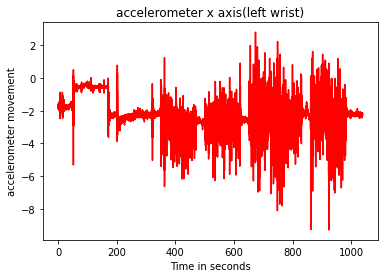

In [6]:
plt.plot(timestamp_total_seconds, part0_dev1["accelerometer x"], color="red")
plt.title("accelerometer x axis(left wrist)")
plt.xlabel("Time in seconds")
plt.ylabel("accelerometer movement")
plt.show()

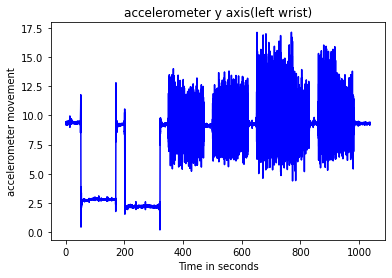

In [7]:
plt.plot(timestamp_total_seconds, part0_dev1["accelerometer y"], color="blue")
plt.title("accelerometer y axis(left wrist)")
plt.xlabel("Time in seconds")
plt.ylabel("accelerometer movement")
plt.show()

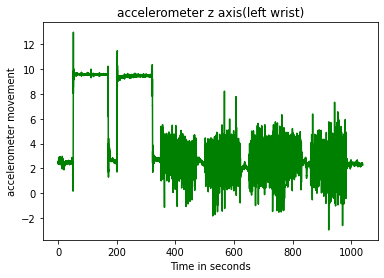

In [8]:
plt.plot(timestamp_total_seconds, part0_dev1["accelerometer z"], color="green")
plt.title("accelerometer z axis(left wrist)")
plt.xlabel("Time in seconds")
plt.ylabel("accelerometer movement")
plt.show()

### Part 3: Windows

The data of each participant is split into windows of a certain amount of seconds

In [ ]:
# The sampling rate of the devices
hertz = 51.2
# the size of the windows in seconds
window_length = 5
nrows_per_window = int(window_length / (1 / hertz))

In [11]:
windows = []
for participant in participant_IDs:
    
    # FOR NOW only the device on the torso is used
    torso_data = forth_trace_data[participant+"dev3"]

    windows = windows + [torso_data[i:i+nrows_per_window] for i in range(0,torso_data.shape[0],nrows_per_window)]

In [ ]:
def is_unique(data):
    # returns True if all values of the data are the same as the first value.
    data_as_array = data.to_numpy()
    return (data_as_array[0] == data_as_array).all()

In [12]:
# FOR NOW only the data with the labels of sitting, standing and walking is used.
# This code creates a subset of windows that only contain the three mentioned labels
# These windows also only contain the same label
sit_stand_walk_windows = []    
for window in windows:
    # checks if every row of the window has the same activity label.
    if is_unique(window["Activity Label"]):
        # checks if the label of the current window corresponds to either sitting, standing or walking
        current_label = window["Activity Label"].to_numpy()[0]
        if current_label == 1 or current_label == 2 or current_label == 4:
            
            sit_stand_walk_windows.append(window)

### Part 4: Features

Features are extracted from the total acceleration of standing, sitting and walking from the accelerometers of each participant.
The output of pandas.describe() is used as the new features, this includes:
Mean, Min, Max, std, and each percentile(25%, 50% and 75%).
The result is a list of features and a list of the labels corresponding to these features.

In [13]:
def calc_total_accel(x, y, z):
    # Returns the total acceleration calculation from three given values: X, Y and Z
    return math.sqrt(x**2 + y**2 + z**2)


def calc_mean_total_accel(dataset):
    # Returns the mean total acceleration of a given set of data
    return statistics.mean(dataset.apply(lambda row: calc_total_accel(row["accelerometer x"],
                                                                      row["accelerometer y"],
                                                                      row["accelerometer z"]), axis=1))


def calc_sensor_orientation(main_axis, second_axis, third_axis):
    # Returns the orientation of a accelerometer sensor axis relative to the horizontal plane.
    return math.degrees(math.atan(main_axis / math.sqrt(second_axis**2 + third_axis**2)))


def calc_mean_sensor_orientation(dataset, main_axis, second_axis, third_axis):
    # Returns the mean the orientation of a accelerometer sensor axis relative to the horizontal plane.
    return statistics.mean(dataset.apply(lambda row: calc_sensor_orientation(row[main_axis],
                                                                             row[second_axis],
                                                                             row[third_axis]), axis=1))


def extract_features(dataset):
    # returns the extracted features from the given dataset
    mean_total_acceleration = calc_mean_total_accel(dataset)
    mean_angle_x = calc_mean_sensor_orientation(dataset, "accelerometer x", "accelerometer y", "accelerometer z")
    mean_angle_y = calc_mean_sensor_orientation(dataset, "accelerometer y", "accelerometer x", "accelerometer z")
    mean_angle_z = calc_mean_sensor_orientation(dataset, "accelerometer z", "accelerometer y", "accelerometer x")    
    return [mean_total_acceleration, mean_angle_x, mean_angle_y, mean_angle_z]

In [14]:
features = []
labels = []
for window in sit_stand_walk_windows:
    features.append(extract_features(window))
    labels.append(window["Activity Label"].to_numpy()[0])

# The data is stored into a NumPy array.
X = np.array(features)
y = np.array(labels)

In [15]:
total_accel_dict = {1: [], 2: [], 4: []}
angle_x_dict = {1: [], 2: [], 4: []}
angle_y_dict = {1: [], 2: [], 4: []}
angle_z_dict = {1: [], 2: [], 4: []}

for count in range(len(features)):
    total_accel_dict[labels[count]].append(features[count][0]) 
    angle_x_dict[labels[count]].append(features[count][1]) 
    angle_y_dict[labels[count]].append(features[count][2]) 
    angle_z_dict[labels[count]].append(features[count][3]) 

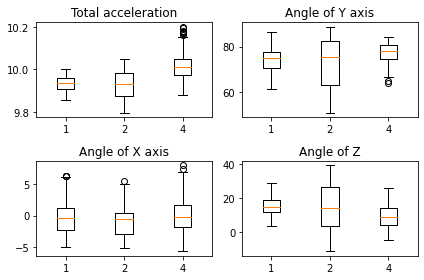

In [16]:
fig, ax = plt.subplots(2, 2)

ax[0,0].title.set_text('Total acceleration')
ax[0,0].boxplot(total_accel_dict.values())
ax[0,0].set_xticklabels(total_accel_dict.keys())

ax[1,0].title.set_text('Angle of X axis')
ax[1,0].boxplot(angle_x_dict.values())
ax[1,0].set_xticklabels(angle_x_dict.keys())

ax[0,1].title.set_text('Angle of Y axis')
ax[0,1].boxplot(angle_y_dict.values())
ax[0,1].set_xticklabels(angle_y_dict.keys())

ax[1,1].title.set_text('Angle of Z')
ax[1,1].boxplot(angle_z_dict.values())
ax[1,1].set_xticklabels(angle_z_dict.keys())

fig.tight_layout()

### Part 5: Basic Supervised classifier testing

Some basic supervised classifier(s) are tested using cross-validation

In [17]:
def get_model_score(model, X_train, X_test, y_train, y_test):
    # This funtion returns the score of a given model using given train and test data/
    model.fit(X_train, y_train)
    return model.score(X_test, y_test)

In [18]:
# The StratifiedKFold function is used, since the data may not have an equal distribution of class labels. 
folds = StratifiedKFold(n_splits=5)

In [19]:
rfc_scores = []

for train_index, test_index in folds.split(X, y):
    X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]    
    
    # Normalisation is seperately applied to the training and testing sets
    X_train = MinMaxScaler().fit_transform(X_train)
    X_test = MinMaxScaler().fit_transform(X_test)
    
    rfc_scores.append(get_model_score(RandomForestClassifier(), X_train, X_test, y_train, y_test))

In [20]:
print(statistics.mean(rfc_scores))

0.6752406217052682
